# Imports

In [24]:
# To make sure we can import h5utils.py from the notebooks folder
import sys
sys.path.append('../')

In [25]:
import os 
import npyx
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pathlib
import optuna
import utils.h5_utils as h5
import random

from pathlib import Path
from npyx.feat import filter_df
from sklearn import preprocessing
from tqdm.auto import tqdm, trange
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import LeaveOneOut
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, ADASYN, RandomOverSampler

from imblearn.under_sampling import RandomUnderSampler
from sklearn.semi_supervised import LabelPropagation, LabelSpreading
from utils.constants import DATA_PATH, CORRESPONDENCE, CENTRAL_RANGE, N_CHANNELS

# Confusion matrix
import seaborn as sns
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42 # necessary to make the text editable
matplotlib.rcParams['ps.fonttype'] = 42

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [26]:
# get relative data folder
PATH = os.path.dirname(os.path.abspath(''))
data_folder = PATH + '/data'
CSV_PATH = data_folder + ("/Aug-09-2022_all_features.csv")


In [27]:
SEED = 1234
h5.set_seed(SEED)

Random seed 1234 has been set.


1234

In [28]:
# Need this for plotting later
DATASET = h5.NeuronsDataset(DATA_PATH, normalise=False)

# Choosing the scaling and the type of dataset we want (full, acg or wf)
# DATASET.min_max_scale()
DATASET.make_full_dataset()
DATASET.make_labels_only()

Reading dataset:   0%|          | 0/1213 [00:00<?, ?it/s]

954 neurons loaded, of which labelled: 77 
259 neurons discarded, of which labelled: 7. More details at the 'discarded_df' attribute.


In [29]:
DATASET.info[0]

'20-03-06_DK186_probe1/357'

In [30]:
df = pd.read_csv(CSV_PATH, index_col=0)

In [33]:
def filter_df(df:pd.DataFrame):
    """
    Filters out datapoints with unusable temporal features.
    """
    features_only = df.iloc[:, 2:]
    bad_idx = []
    for i, row in features_only.iterrows():
        value, count = np.unique(row.to_numpy(), return_counts=True)
        zeros = count[value == 0]
        if  zeros.size > 0 and zeros > 5:
            bad_idx.append(i)
    keep = [i for i in range(len(df)) if i not in bad_idx]
    return df.iloc[keep]

In [34]:
def generate_train_and_labels(df: pd.DataFrame, info_idx = [0, 1 , 2 ,18]):
    info = df.iloc[:, info_idx]
    features = df.iloc[:, ~np.isin(np.arange(len(df.columns)), info_idx)]
    return features.copy(), info.iloc[:, 0].copy()

In [35]:
X, y = generate_train_and_labels(filter_df(df))

In [36]:
# Converting text labels to numbers
LABELLING = {'PkC_cs': 5, 'PkC_ss': 4, 'MFB':3, 'MLI':2, 'GoC':1, 'GrC':0}

# To do the inverse
CORRESPONDENCE = {5: 'PkC_cs', 4: 'PkC_ss', 3 : 'MFB', 2: 'MLI', 1:'GoC', 0:'GrC'}

y.replace(to_replace = LABELLING, inplace = True)

In [37]:
y.value_counts()

1    25
4    21
5    11
3     9
0     6
2     5
Name: label, dtype: int64

# Random forest

In [38]:
best_params = optuna.load_study("random-forest-feat-eng", f"sqlite:///{PATH}/random-forest-feat-eng.db").best_params

In [39]:
N_LOOS = 50

In [40]:
kfold = LeaveOneOut()

f1_scores = []
confusions_list = []

hyper_true_targets = []
hyper_preds = []

for loo in tqdm(range(N_LOOS), position = 0, leave = True, desc = "Random Forest runs"):
    
    train_accuracies = []
    true_targets = []
    model_pred = []
    dummy_pred = []
    seed = np.random.choice(2**32)
    for fold, (train_idx, val_idx) in tqdm(
        enumerate(kfold.split(X, y)),
        leave=False,
        position=1,
        desc="Cross-validating",
        total=len(X),
    ):

        X_train = X.iloc[train_idx]
        y_train = y.iloc[train_idx]
        X_test = X.iloc[val_idx]
        y_test = y.iloc[val_idx]

        oversample = RandomOverSampler(random_state=seed)

        X_big, y_big = oversample.fit_resample(X_train, y_train)

        model = RandomForestClassifier(**best_params, random_state=seed)

        # fit the model on the data
        model.fit(X_big, y_big)
        pred = model.predict(X_test)
        train_accuracies.append(model.score(X_train, y_train))

        true_targets.append(y_test)
        model_pred.append(pred)
        

        ####### Now doing something similar with a Dummy Classifier so that we can plot a baseline #########
        dummy = DummyClassifier(strategy="uniform")
        # fit the model on the data
        dummy.fit(X_big, y_big)
        pred = dummy.predict(X_test)

        dummy_pred.append(pred)
        
    confusion = confusion_matrix(true_targets, model_pred, labels=np.arange(0, 6))
    confusions_list.append(confusion)
    f1 = f1_score(true_targets, model_pred, average='macro')
    f1_scores.append(f1)
    hyper_true_targets.append(np.array(true_targets))
    hyper_preds.append(np.array(model_pred))



mean_train = np.array(train_accuracies).mean()
mean_validation = (np.array(true_targets)==np.array(model_pred)).mean()
mean_dummy = (np.array(true_targets)==np.array(dummy_pred)).mean()
print(
f"Mean train accuracy is {mean_train:.3f} while LOO accuracy is {mean_validation:.3f}"
)
print(f"Dummy LOO accuracy is {mean_dummy:.3f} ")
print(f"Mean LOO f1 score across random forests is {np.array(f1_scores).mean():.3f}")


Random Forest runs:   0%|          | 0/50 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Mean train accuracy is 0.976 while LOO accuracy is 0.714
Dummy LOO accuracy is 0.182 
Mean LOO f1 score across random forests is 0.568


In [41]:
X.to_numpy().shape

(77, 32)

In [42]:
max(f1_scores)

0.6345661745661746

In [43]:
np.array(train_accuracies).std()

0.005626137263552375

In [44]:
np.array(f1_scores).std()

0.03522090419255264

# Accuracy plots

# Confusion matrix

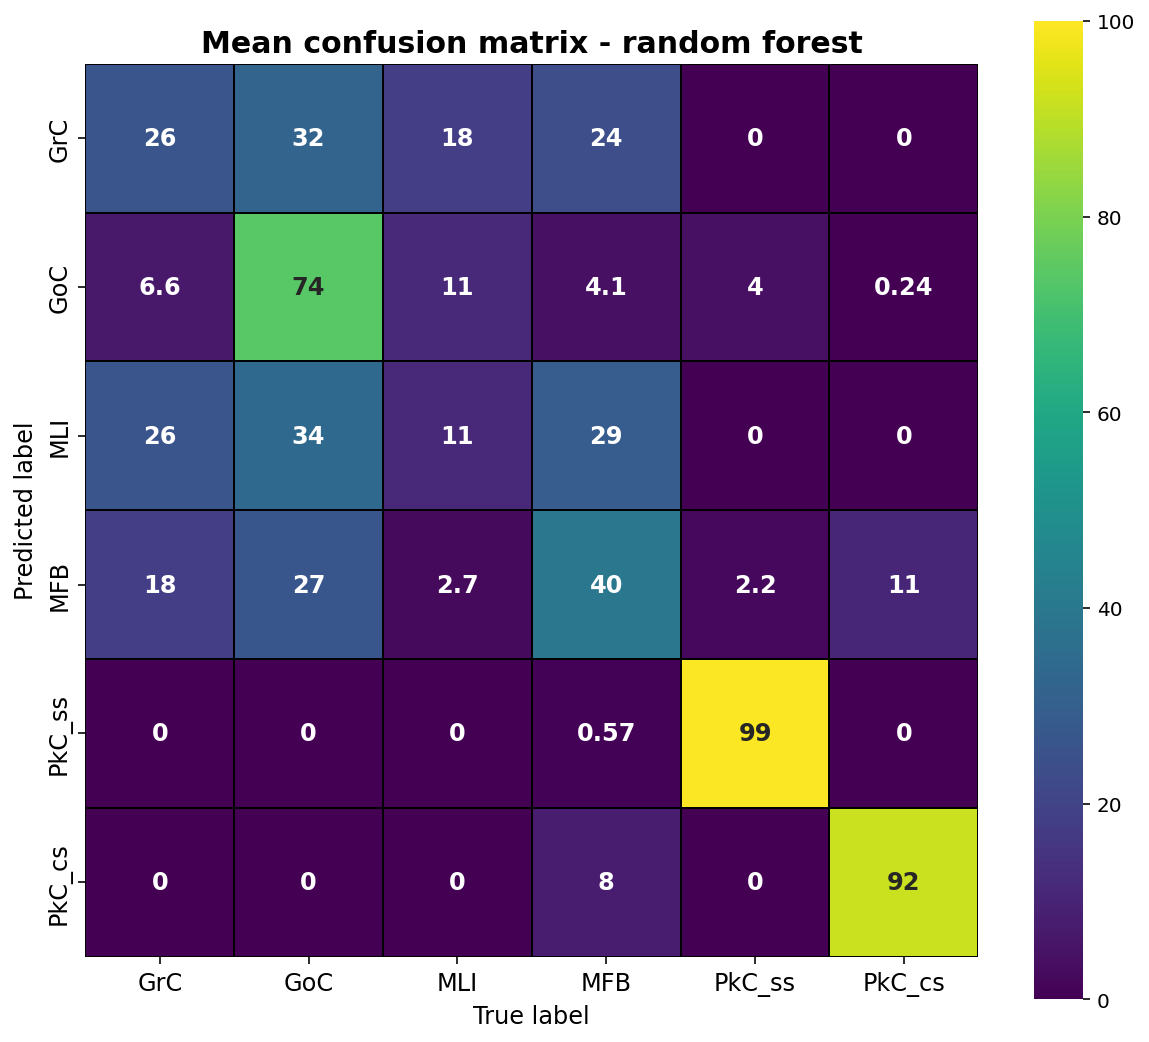

In [45]:
confusion = np.stack(confusions_list, axis = 2).mean(axis = 2) # confusion_matrix(true_2, predicted_2, labels = np.arange(0,6))
mean_confusion = confusion / (np.sum(confusion, axis = 1)[:, np.newaxis]) * 100 # normalising and showing percentage
mask = ~(np.eye(mean_confusion.shape[0]).astype(bool))

fig, ax = plt.subplots(figsize=(10, 9))
ax = sns.heatmap(
    mean_confusion,
    annot=mean_confusion,
    cmap="viridis",
    cbar=True,
    linewidths=1,
    linecolor="black",
    square=True,
    vmin=0,
    vmax=100,
    annot_kws={"fontsize": 12, "fontweight": "bold"},
)

x_labels = [int(ax.get_xticklabels()[i].get_text()) for i in range(6)]
y_labels = [int(ax.get_yticklabels()[i].get_text()) for i in range(6)]

ax.set_xticklabels(
    pd.Series(x_labels).replace(to_replace=CORRESPONDENCE).to_numpy(),
    fontsize=12,
)
ax.set_yticklabels(
    pd.Series(y_labels).replace(to_replace=CORRESPONDENCE).to_numpy(),
    fontsize=12,
)
ax.set_title("Mean confusion matrix - random forest", fontsize=15, fontweight="bold")
ax.set_xlabel("True label", fontsize=12)
ax.set_ylabel("Predicted label", fontsize=12);

plt.savefig("mean_confusion_matrix_random forest.pdf")

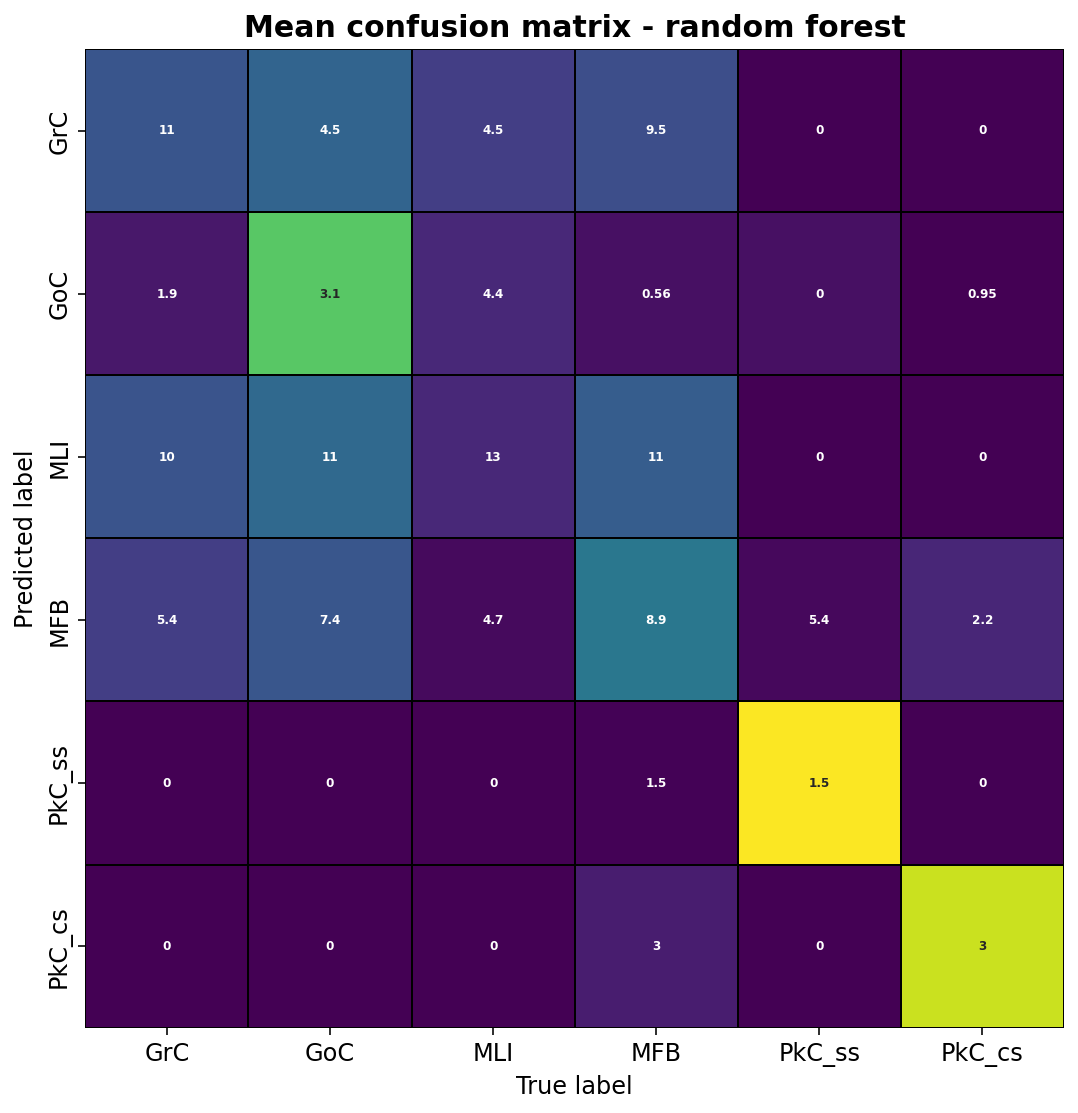

In [46]:
confusion = np.stack(confusions_list, axis = 2).mean(axis = 2) # confusion_matrix(true_2, predicted_2, labels = np.arange(0,6))
mean_confusion = confusion / (np.sum(confusion, axis = 1)[:, np.newaxis]) * 100 # normalising and showing percentage
std_confusion = np.stack(confusions_list, axis = 2).std(axis = 2) / (np.sum(confusion, axis = 1)[:, np.newaxis]) * 100 # normalising and showing percentage
mask = ~(np.eye(mean_confusion.shape[0]).astype(bool))

fig, ax = plt.subplots(figsize=(10, 9))
ax = sns.heatmap(
    mean_confusion,
    annot=std_confusion,
    cmap="viridis",
    cbar=False,
    linewidths=1,
    linecolor="black",
    square=True,
    vmin=0,
    vmax=100,
    annot_kws={"fontsize": 6, "fontweight": "bold", "verticalalignment": "bottom", "horizontalalignment": "right"},
)
x_labels = [int(ax.get_xticklabels()[i].get_text()) for i in range(6)]
y_labels = [int(ax.get_yticklabels()[i].get_text()) for i in range(6)]

ax.set_xticklabels(
    pd.Series(x_labels).replace(to_replace=CORRESPONDENCE).to_numpy(),
    fontsize=12,
)
ax.set_yticklabels(
    pd.Series(y_labels).replace(to_replace=CORRESPONDENCE).to_numpy(),
    fontsize=12,
)
ax.set_title("Mean confusion matrix - random forest", fontsize=15, fontweight="bold")
ax.set_xlabel("True label", fontsize=12)
ax.set_ylabel("Predicted label", fontsize=12);
plt.savefig("std_confusion_matrix_random forest.pdf")

## Mistakes breakdown

In [58]:
boolean_preds = []
for i in range(N_LOOS):
    boolean_preds.append(hyper_true_targets[i].ravel()==hyper_preds[i].ravel())

In [60]:
mistakes = (len(boolean_preds) - np.stack(boolean_preds, axis = 0).sum(0))

In [73]:
predictions_array = np.stack(hyper_preds, axis = 0).squeeze()

In [62]:
top5_mistakes_idx = np.argsort(mistakes)[::-1][:5]
top5_mistakes_count = mistakes[top5_mistakes_idx]

Cell: GoC mistaken 50 times. 

Most common mislabelling: PkC_ss 



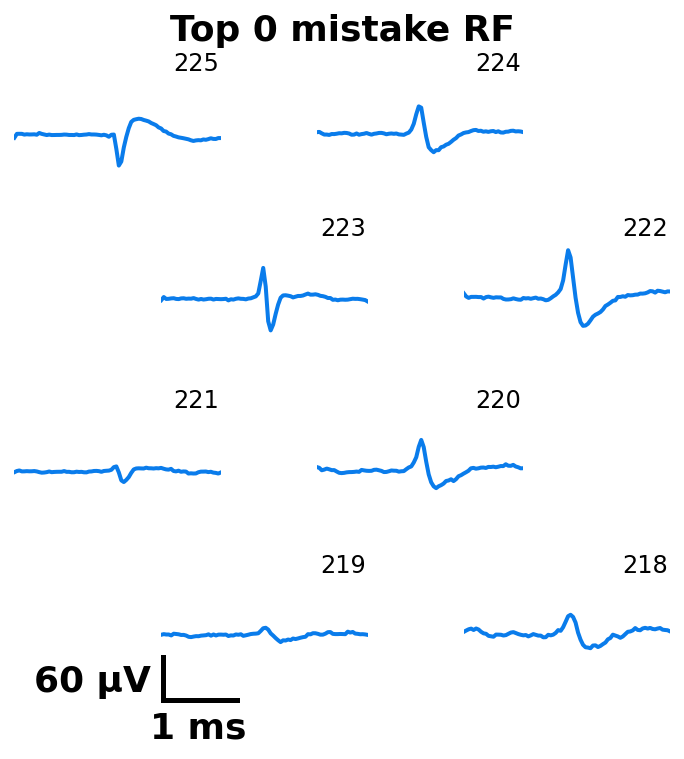

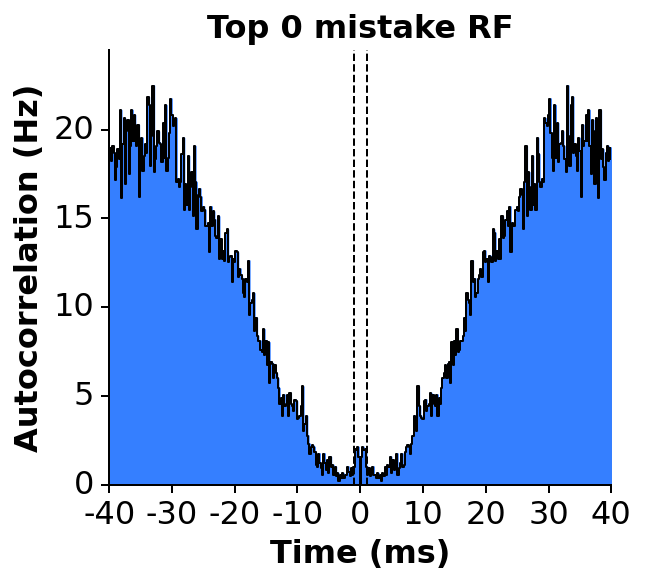


 ----- 

Cell: GoC mistaken 50 times. 

Most common mislabelling: MFB 



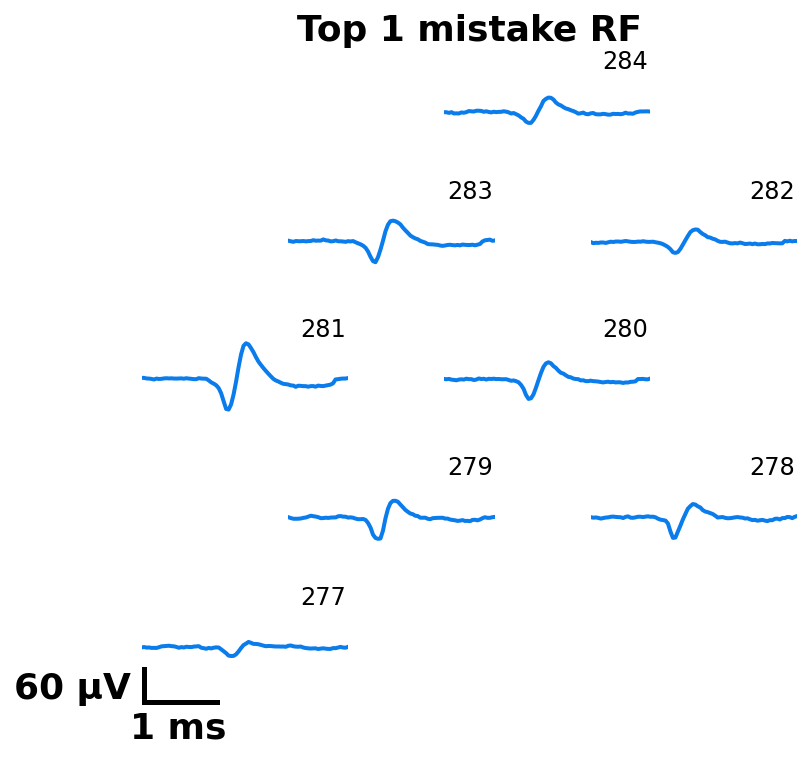

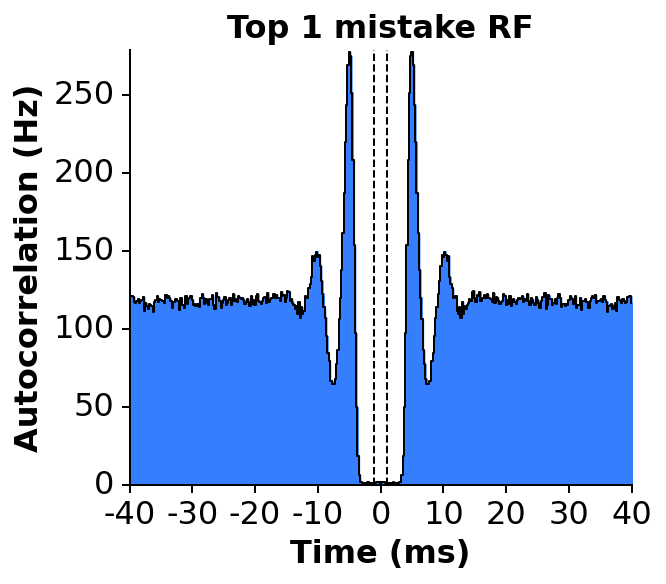


 ----- 

Cell: GoC mistaken 50 times. 

Most common mislabelling: GrC 



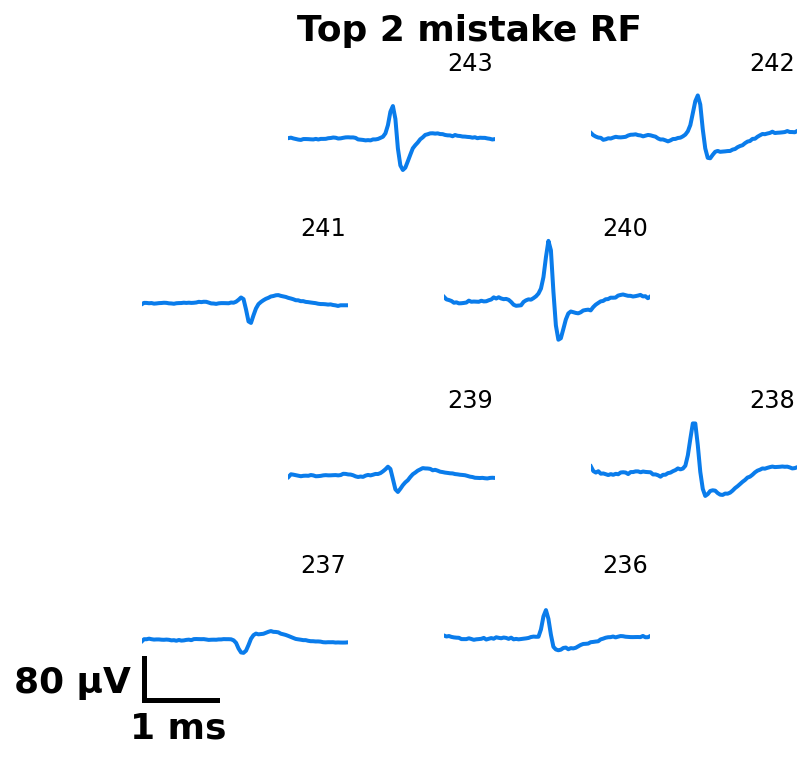

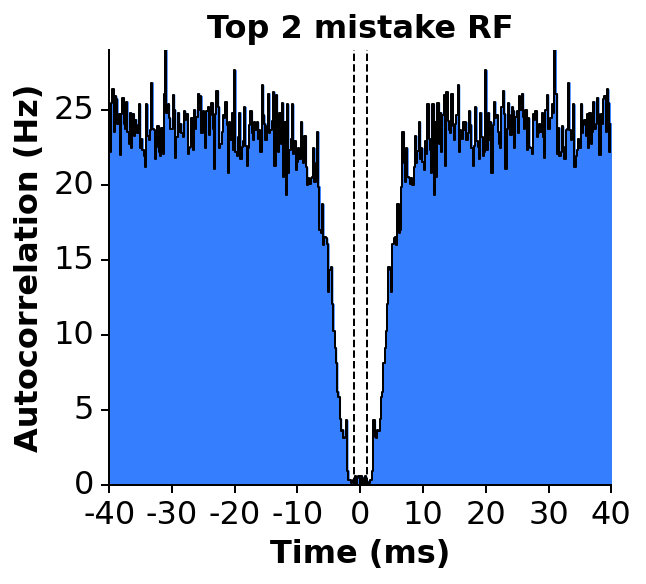


 ----- 

Cell: PkC_cs mistaken 50 times. 

Most common mislabelling: GoC 



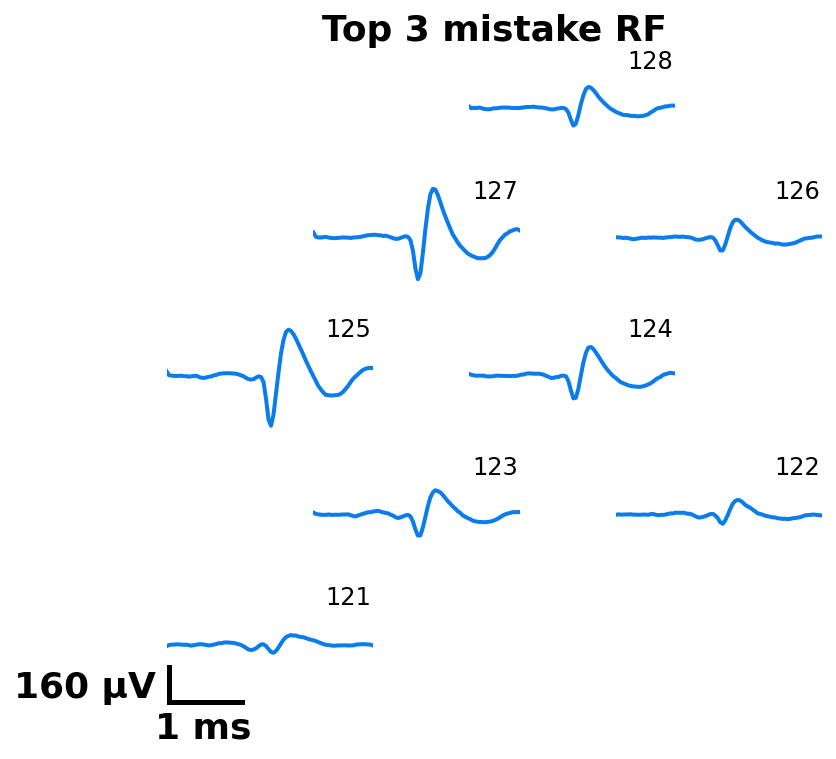

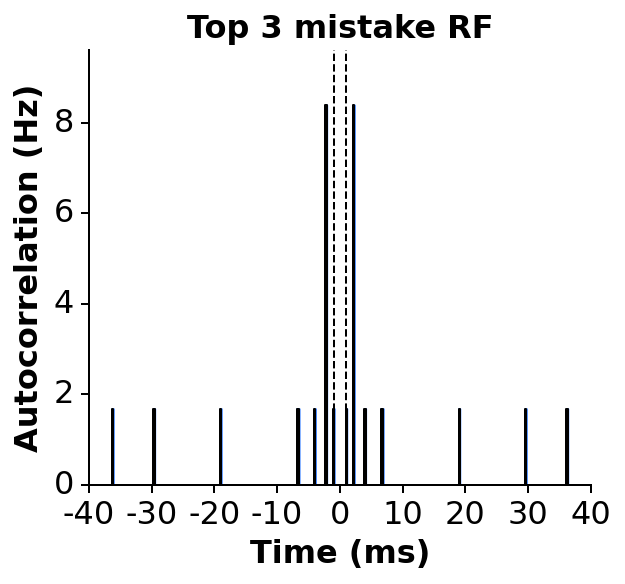


 ----- 

Cell: PkC_ss mistaken 50 times. 

Most common mislabelling: GoC 



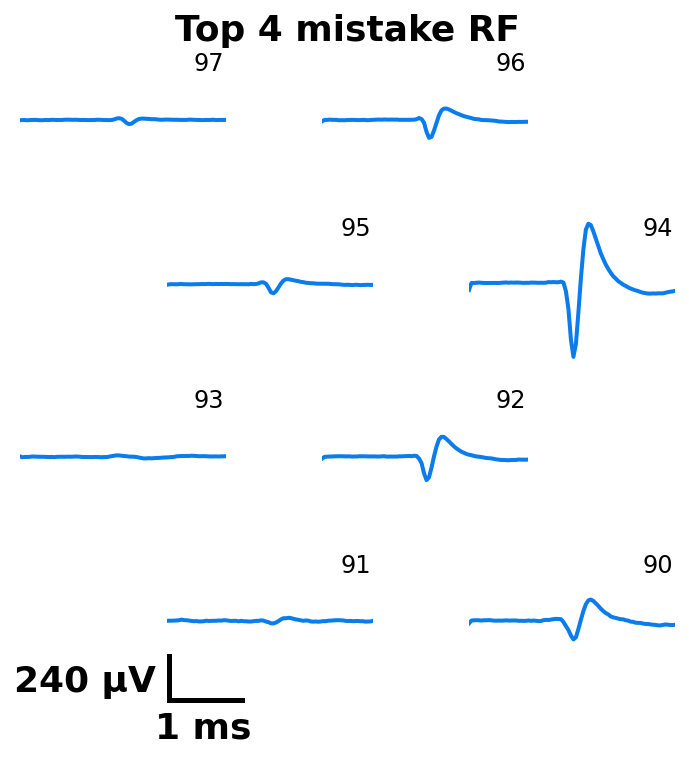

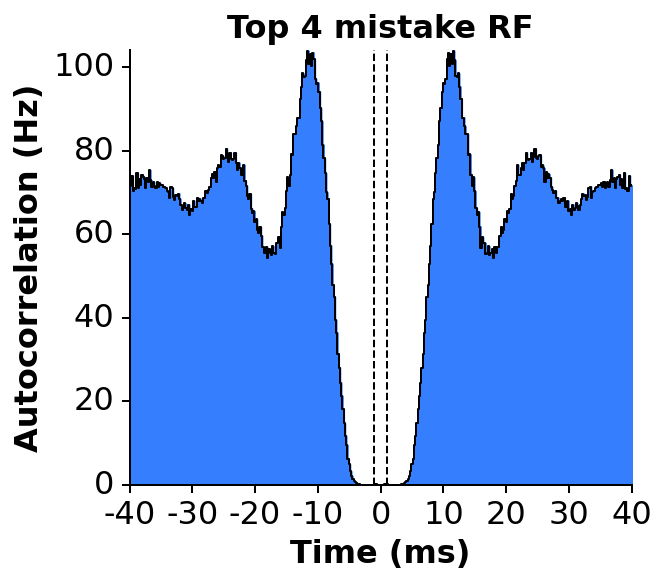


 ----- 



In [94]:
for i, mistake_idx in enumerate(top5_mistakes_idx):
    print(f"Cell: {df.iloc[mistake_idx]['label']} mistaken {mistakes[mistake_idx]} times. \n")
    print(f"Most common mislabelling: {CORRESPONDENCE[np.bincount(predictions_array[:,mistake_idx]).argmax()]} \n")
    npyx.plot_wvf(df.iloc[mistake_idx]["dp"], df.iloc[mistake_idx]["unit"], use_dsmatch = True, saveFig=True, figw_inch = 6, figh_inch=6, title=f"Top {i} mistake RF",);
    npyx.plot_acg(df.iloc[mistake_idx]["dp"], df.iloc[mistake_idx]["unit"], 0.2, 80, saveFig = True, title=f"Top {i} mistake RF",);
    plt.show()
    print("\n ----- \n")
